## Load Packages

In [1]:
using Dates, LinearAlgebra

include("jlFiles/printmat.jl")
include("jlFiles/printTable.jl")

printTable2

In [2]:
using Plots

#pyplot(size=(600,400))              #pyplot() or gr()
gr(size=(480,320))
default(fmt = :svg)

# The MV Frontier


MV analysis starts with providing the vector of expected returns $\mu$ and the covariance matrix $\Sigma$ of the investable assets.

Then, it plots the "mean variance" frontier: it is a scatter plot showing the lowest possible portfolio standard deviation, Std$(R_p)$, on the horizontal axis at a required average return, $\text{E}R_p=\mu^*$, on the vertical axis. Clearly, we consider many different $\mu^*$ values to create the scatter.

Remember: to calculate the expected return and the variance of a portfolio with portfolio weights in the vector $w$, use 

$\text{E}R_p = w'\mu$ and 

$\text{Var}(R_p) = w'\Sigma w$.

Also, the sum of the portfolio weights should be one.

# MV Frontier  with Two Assets

With only two investable assets, all portfolios of them are on the MV frontier. We can trace out the entire MV frontier by calculating the means and standard deviations of a range of portfolios with different weights ($w_1,1-w_1$) on the two assets.

In [3]:
μ = [11.5; 6]/100            #means
Σ  = [166   58;              #covariance matrix
       58  100]/100^2

printblue("expected returns, %:")
printmat(μ*100)
printblue("covariance matrix, bp:")
printmat(Σ*100^2)

expected returns, %:
    11.500
     6.000

covariance matrix, bp:
   166.000    58.000
    58.000   100.000



In [4]:
w₁ = 1.5:-0.05:-0.5           #different possible weights on asset 1
n  = length(w₁)

(ERp,StdRp) = (fill(NaN,n),fill(NaN,n))
for i = 1:n
    #local w                  #only needed in REPL/script
    w        = [w₁[i];1-w₁[i]]
    ERp[i]   = w'μ
    StdRp[i] = sqrt(w'Σ*w)
end

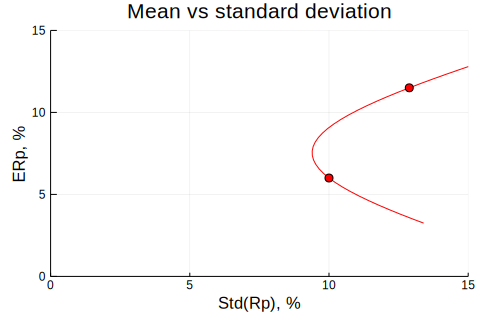

In [5]:
plot( StdRp*100,ERp*100,
      legend = nothing,
      linecolor = :red,
      xlim = (0,15),
      ylim = (0,15),
      title = "Mean vs standard deviation",
      xlabel = "Std(Rp), %",
      ylabel = "ERp, %" )

scatter!(sqrt.(diag(Σ))*100,μ*100,markercolor=:red)

# Calculating the MV Frontier: 3 or More (Risky) Assets

With 3 or more assets we have to solve the optimization problem

$\min \text{Var}(R_p) \: \text{ s.t. } \: \text{E}R_p = \mu^*$,

and clearly also that the sum of portfolio weights is one. We do not (at this point) impose any further restrictions.

This can be done with a numerical minimization routine or by linear algebra (at least when we do not put any further restrictions on the portfolio weights). The next cells use the linear algebra approach. 

In [6]:
μ = [11.5; 9.5; 6]/100          #expected returns
Σ  = [166  34  58;              #covariance matrix
       34  64   4;
       58   4 100]/100^2
Rf = 0.03

printblue("μ and Rf in %:")
printmat(μ*100)
printmat(Rf*100)
printblue("Σ in bp:")
printmat(Σ*100^2)

μ and Rf in %:
    11.500
     9.500
     6.000

     3.000

Σ in bp:
   166.000    34.000    58.000
    34.000    64.000     4.000
    58.000     4.000   100.000



In [7]:
w = [0 0.22 0.02 0.25;            #different portfolios (one in each column)
     1 0.30 0.63 0.68; 
     0 0.48 0.35 0.07]

μσ = fill(NaN,2,size(w,2))
for i = 1:size(w,2)
    μσ[:,i] = [w[:,i]'μ,sqrt(w[:,i]'Σ*w[:,i])]*100
end

printlnPs("mean and std (in %) of portfolio ")
printTable(μσ,["A","1","2","3"],["mean","std"])

mean and std (in %) of portfolio 
             A         1         2         3
mean     9.500     8.260     8.315     9.755
std      8.000     7.398     6.415     7.378



All portfolios on the MV frontier of risky assets only have (a vector of) portfolio weights as in

$w = \Sigma^{-1}(\mu \lambda + \mathbf{1} \delta)$, 

where the scalars $\lambda$ and $\delta$ depend on $(\mu,\Sigma,\mu^*)$ (see below for the details) and where $\mathbf{1}$ is a vector of ones. 

Some of the intermediate calculations are as follows. (Later on we put it all in a function)

In [8]:
μstar = 0.1            #required average return

n    = length(μ)
 
Σ_1  = inv(Σ)

printblue("The steps of calculating a MV portfolio at μstar=$μstar:")

println("inv(Σ):")
printmat(Σ_1)

A    = μ'Σ_1*μ
B    = μ'Σ_1*ones(n)
C    = ones(n)'Σ_1*ones(n)
printlnPs("A, B, C: ",[A B C ])

λ    = (C*μstar - B)/(A*C-B^2)
δ    = (A-B*μstar)/(A*C-B^2)
printlnPs("λ and δ: ",[λ δ])

w    = Σ_1 *(μ*λ + ones(n)*δ)  #in Julia, we could do Σ_1 *(μ*λ .+ δ)
println("w: ")
printmat(w)

The steps of calculating a MV portfolio at μstar=0.1:
inv(Σ):
    85.735   -42.545   -48.024
   -42.545   177.754    17.566
   -48.024    17.566   127.151

 A, B, C:      1.804    19.759   244.634
 λ and δ:      0.093    -0.003
w: 
     0.288
     0.690
     0.022



In [9]:
"""
Calculate the std and weights of a portfolio (with mean return μstar) on MVF of risky assets
"""
function MVCalc(μstar,μ,Σ) 
    n    = length(μ)
    Σ_1  = inv(Σ)
    A    = μ'Σ_1*μ
    B    = μ'Σ_1*ones(n)
    C    = ones(n)'Σ_1*ones(n)
    λ    = (C*μstar - B)/(A*C-B^2)
    δ    = (A-B*μstar)/(A*C-B^2)
    w    = Σ_1 *(μ*λ.+δ)
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end

MVCalc

In [10]:
(StdAt10,wAt10) = MVCalc(0.1,μ,Σ)
printlnPs("Testing: std and w of the portfolio with a mean return of 10%: ",StdAt10)
printmat(wAt10)

Testing: std and w of the portfolio with a mean return of 10%:      0.077
     0.288
     0.690
     0.022



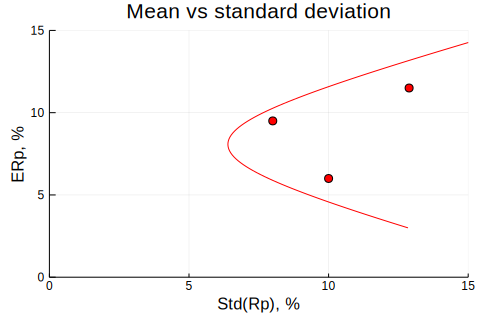

In [11]:
μstar  = range(Rf,stop=0.15,length=101)
L      = length(μstar)
StdRp  = fill(NaN,L)                      #loop over different required average returns, (μstar)
for i = 1:L
    StdRp[i] = MVCalc(μstar[i],μ,Σ)[1]   #[1] picks out only the first function output
end

plot( StdRp*100,μstar*100,
      legend = nothing,
      linecolor = :red,
      xlim = (0,15),
      ylim = (0,15),
      title = "Mean vs standard deviation",
      xlabel = "Std(Rp), %",
      ylabel = "ERp, %" )

scatter!(sqrt.(diag(Σ))*100,μ*100,markercolor=:red)

# Calculating the MV Frontier (of Risky and Riskfree Assets)

All portfolios on the MV frontier of both risky and riskfree have (a vector of) portfolio weights on the risky assets as in 

$w=\frac{\mu^{\ast}-R_{f}}{(\mu^{e})^{\prime}\Sigma^{-1}\mu^{e}}\Sigma^{-1}
\mu^{e}$, 

where $\mu^*$ is the required average return.

The weight of the riskfree asset is $1-\mathbf{1}'w$

In [12]:
"""
Calculate the std of a portfolio (with mean μstar) on MVF of (Risky,Riskfree) 
"""
function MVCalcRf(μstar,μ,Σ,Rf)
    μᵉ    = μ .- Rf                 #expected excess returns
    Σ_1   = inv(Σ)
    w     = (μstar-Rf)/(μᵉ'Σ_1*μᵉ) * Σ_1*μᵉ
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end

MVCalcRf

In [13]:
(StdAt10Rf,wAt10Rf) = MVCalcRf(0.1,μ,Σ,Rf)
printlnPs("Testing: std and w of the portfolio with a mean return of 10%: ",StdAt10Rf)
printmat(wAt10Rf)

Testing: std and w of the portfolio with a mean return of 10%:      0.076
     0.257
     0.707
     0.073



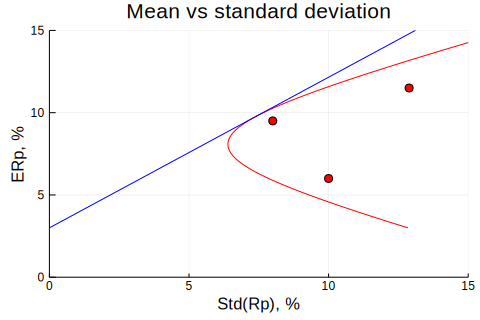

In [14]:
StdRpRf  = fill(NaN,L)                 #loop over required average returns (μstar)
for i = 1:L
    StdRpRf[i] = MVCalcRf(μstar[i],μ,Σ,Rf)[1]
end

plot( [StdRp StdRpRf]*100,μstar*100,
      legend = nothing,
      linecolor = [:red :blue],
      xlim = (0,15),
      ylim = (0,15),
      title = "Mean vs standard deviation",
      xlabel = "Std(Rp), %",
      ylabel = "ERp, %" )

scatter!(sqrt.(diag(Σ))*100,μ*100,markercolor=:red)

# Tangency Portfolio

The tangency portfolio is a particular portfolio on the MV frontier of risky and riskfree, where the weights on the risky assets sum to one. It is therefore also on the MV frontier of risky assets only. The vector of portfolio weights is

$w_{T}=\frac{\Sigma^{-1}\mu^{e}}{\mathbf{1}^{\prime}\Sigma^{-1}\mu^{e}}$

In [15]:
function MVTangencyP(μ,Σ,Rf)           #calculates the tangency portfolio
    n     = length(μ)
    μᵉ    = μ .- Rf                    #expected excess returns
    Σ_1   = inv(Σ)
    w     = Σ_1 *μᵉ/(ones(n)'Σ_1*μᵉ)
    muT   = w'μ + (1-sum(w))*Rf
    StdT  = sqrt(w'Σ*w)
    return w,muT,StdT
end

MVTangencyP (generic function with 1 method)

In [16]:
(wT,μT,σT) = MVTangencyP(μ,Σ,Rf)
println("Tangency portfolio: ")
printmat(wT)
printlnPs("mean and std of tangency portfolio, %: ",[μT σT]*100)

Tangency portfolio: 
     0.248
     0.682
     0.070

mean and std of tangency portfolio, %:      9.750     7.372


By mixing the tangency portfolio and the riskfree, we can create any point on the MV frontier of risky and riskfree (also called the Capital Market Line, CML). 

The code below shows the expected return and standard deviation of several portfolio (different $v$ values) of the form

$R_p = v R_T + (1-v)R_f$ where $R_T=w_T'R$

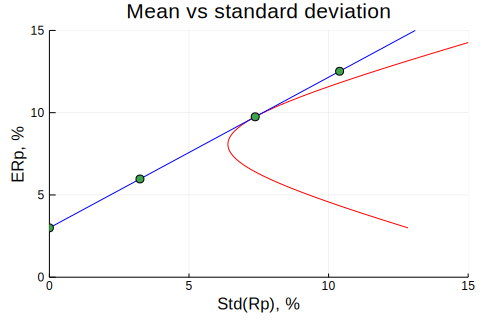

In [17]:
v = [0;0.44;1;1.41]                                 #try different mixes of wT and Rf

(ERLev,StdLev)  = (similar(v),similar(v))           #to store results in
for i = 1:length(v)                    #loop over different v values (mix of wT and Rf)
    ERLev[i]   = v[i]'μT + (1-v[i])*Rf     #portfolio with v[i] in wT and 1-v[i] in Rf
    StdLev[i]  = abs(v[i])*σT
end

plot( [StdRp StdRpRf]*100,μstar*100,
      legend= nothing,
      linecolor = [:red :blue],
      xlim = (0,15),
      ylim = (0,15),
      title = "Mean vs standard deviation",
      xlabel = "Std(Rp), %",
      ylabel = "ERp, %" )

scatter!(StdLev*100,ERLev*100)

## Examples of Tangency Portfolios

In [18]:
μb = [9; 6]/100                     #means
Σb = [ 256  0;
      0    144]/100^2
Rfb = 1/100
wT, = MVTangencyP(μb,Σb,Rfb)
printmat(wT)

wT, = MVTangencyP([13; 6]/100,Σb,Rfb)
printmat(wT)

Σb = [ 1  -0.8;
      -0.8    1]
wT, = MVTangencyP(μb,Σb,Rfb)
printmat(wT)

Σb = [ 1  0.8;
      0.8    1]
wT, = MVTangencyP(μb,Σb,Rfb)
printmat(wT)

     0.474
     0.526

     0.574
     0.426

     0.513
     0.487

     1.538
    -0.538



# Drawing the MV Frontier Revisited (extra)

Recall: with only two investable assets, all portfolios of them are on the MV frontier.

We apply this idea by using the global minimum variance portfolio (see below for code) and the tangency portfolios (see above).

In [19]:
"""
Calculate the global minimum variance portfolio
"""
function MVMinimumVarP(μ,Σ,Rf)
    n     = length(μ)
    μᵉ    = μ .- Rf
    Σ_1   = inv(Σ)
    w     = Σ_1*ones(n)/(ones(n)'Σ_1*ones(n))
    mu    = w'μ + (1-sum(w))*Rf
    Std   = sqrt(w'Σ*w)
    return w,mu,Std
end

MVMinimumVarP

In [20]:
(wT,μT,σT) = MVTangencyP(μ,Σ,Rf)
(wMvp,muMvp,StdMvp) = MVMinimumVarP(μ,Σ,Rf)
println("Tangency and minimum variance portfolios: ")
printmat([wT wMvp])

Tangency and minimum variance portfolios: 
     0.248    -0.020
     0.682     0.625
     0.070     0.395



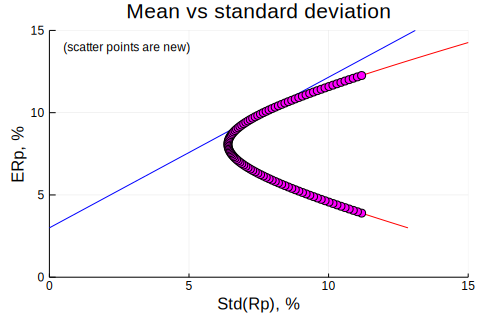

In [21]:
v = range(-2.5,stop=2.5,length=101)          #try different mixes of wT and wMvp

(ERLev,StdLev)  = (similar(v),similar(v))
for i = 1:length(v)
    #local w                                #only needed in REPL/script
    w          = v[i]*wT + (1-v[i])*wMvp    #portfolio with v[i] in wT and 1-v[i] in wMvp
    ERLev[i]   = w'μ
    StdLev[i]  = sqrt(w'Σ*w)
end

plot( [StdRp StdRpRf]*100,μstar*100,
      legend = nothing,
      linecolor = [:red :blue],
      xlim = (0,15),
      ylim = (0,15),
      title = "Mean vs standard deviation",
      xlabel = "Std(Rp), %",
      ylabel = "ERp, %",
      annotation = (0.5,14,text("(scatter points are new)",8,:left)) )

scatter!(StdLev*100,ERLev*100,markercolor=:magenta)

# MV Portfolio Weights Directly from the First Order Conditions (extra)

Instead of manually combining the first order conditions to get expressions for the portfolio weights, we could instead write down the first conditions on matrix/vector form and just solve the system.

In [22]:
function MVCalcX(μstar,μ,Σ) #the std of a portfolio on MVF of risky assets
    n    = length(μ)
    A     = [Σ        μ ones(n);
             μ'       0 0;
             ones(n)' 0 0];
    wλδ    = A\[zeros(n);μstar;1]
    w     = wλδ[1:n]
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end

function MVCalcRfX(μstar,μ,Σ,Rf)           #calculates the std of a portfolio
    n     = length(μ)                       #on MVF of (Risky,Riskfree) 
    μᵉ    = μ .- Rf
    A     = [Σ μᵉ;
            μᵉ' 0]
    wλ    = A\[zeros(n);(μstar-Rf)]
    w     = wλ[1:n]
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end

MVCalcRfX (generic function with 1 method)

In [23]:
wAt10  = MVCalc(0.1,μ,Σ)[2]
wAt10X = MVCalcX(0.1,μ,Σ)[2]
printlnPs("w of the portfolio (risky only) with a mean return of 10%: ")
printmat([wAt10 wAt10X])


wAt10Rf  = MVCalcRf(0.1,μ,Σ,Rf)[2]
wAt10RfX = MVCalcRfX(0.1,μ,Σ,Rf)[2]
printlnPs("w of the portfolio with a mean return of 10%: ")
printmat([wAt10Rf wAt10RfX])

w of the portfolio (risky only) with a mean return of 10%: 
     0.288     0.288
     0.690     0.690
     0.022     0.022

w of the portfolio with a mean return of 10%: 
     0.257     0.257
     0.707     0.707
     0.073     0.073

